In [62]:
import pandas as pd

## 1. Loading in data

In [63]:
data = pd.read_csv("data/diabetes.csv")

In [4]:
data.head(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0


In [5]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
data.shape

(768, 9)

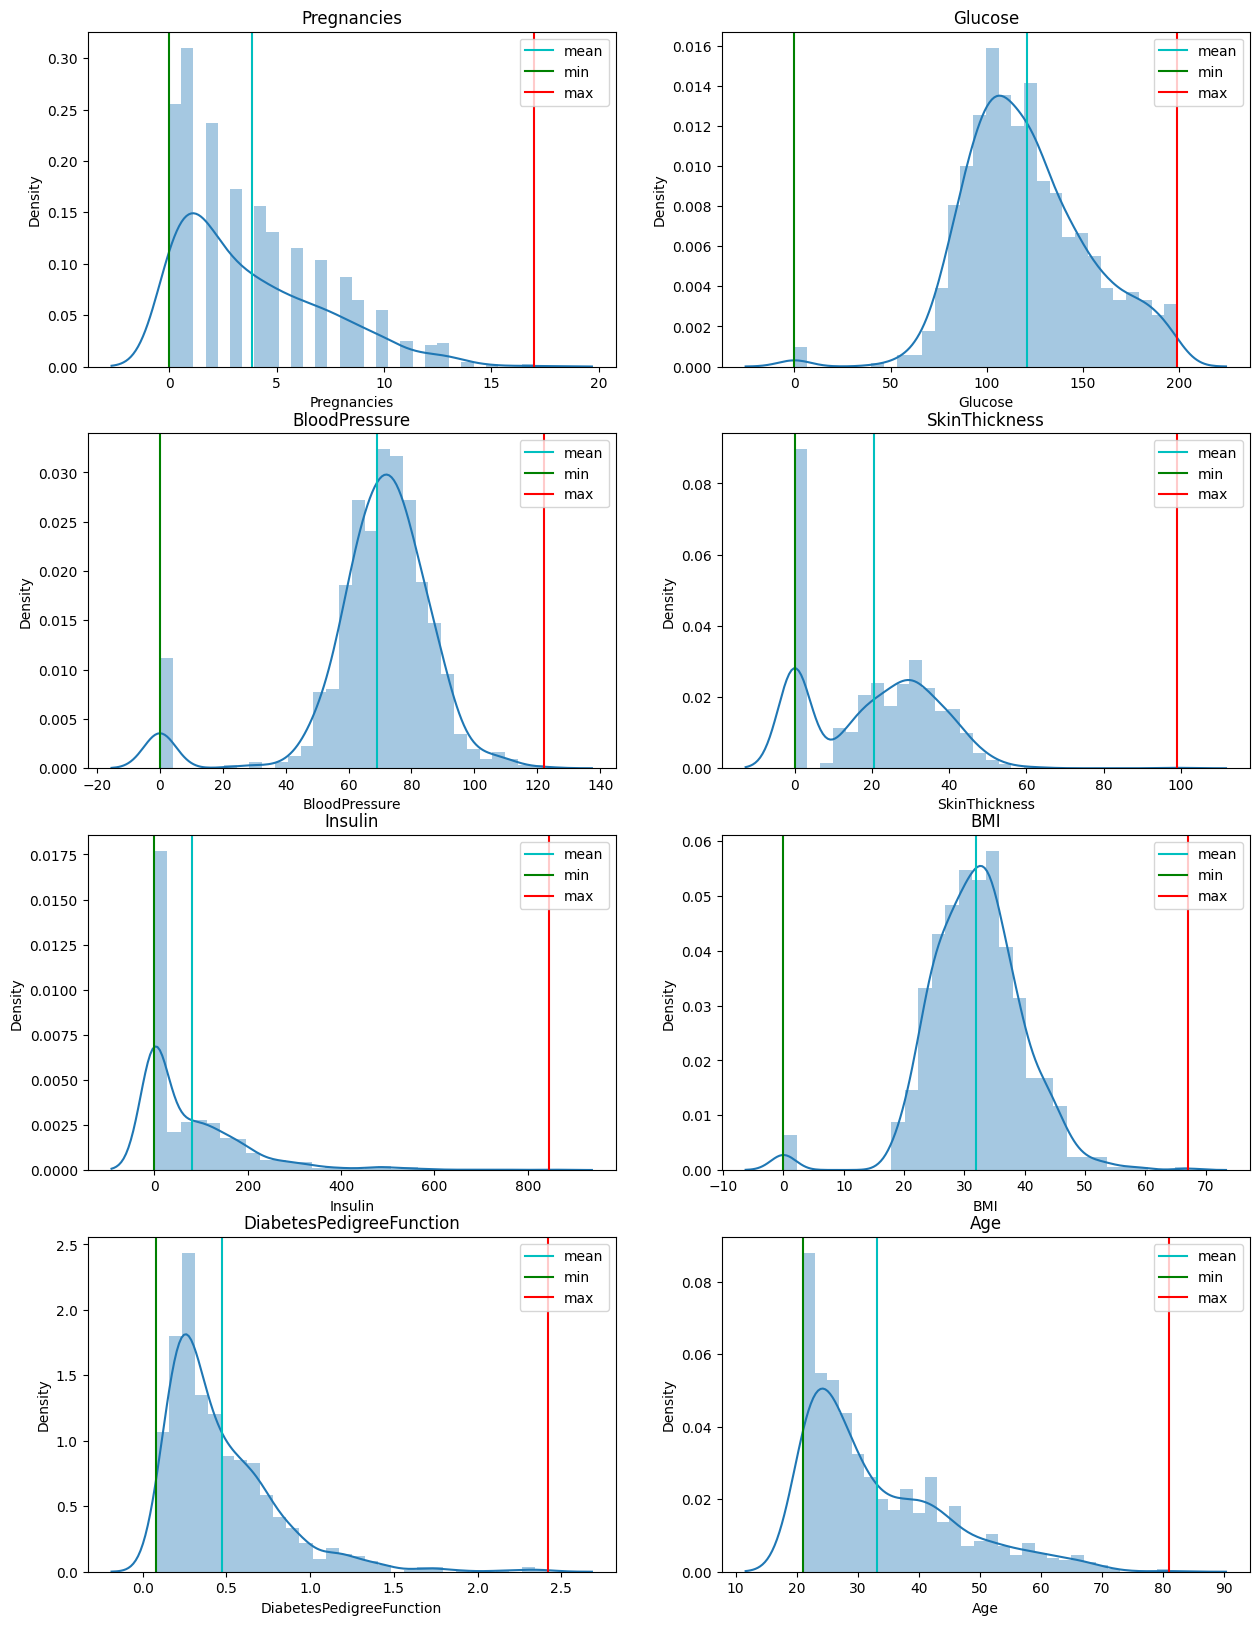

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
col = list(data.iloc[:,:-1].columns)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax = fig.add_subplot()

# plt.figure(figsize=(15,15))
for i in range(len(col)):
    plt.subplot(4,2,i+1)
    sns.distplot( data[col[i]], bins=30)
    plt.axvline(data[col[i]].mean(), color='c', label='mean')
    plt.axvline(data[col[i]].min(), color='g', label='min')
    plt.axvline(data[col[i]].max(), color='r', label='max')        
    plt.legend(loc='upper right')
    plt.title(col[i])
plt.show()

### Is there any pre-processing step that we can do?

## 2. Train test split

In [65]:
from sklearn.model_selection import train_test_split
input_data = data.iloc[:,:-1]
output_data = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.3, random_state=42,stratify=output_data)

### Let's try to do something with AdaBoost

In [66]:
from sklearn.ensemble import AdaBoostClassifier


In [67]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

In [68]:
clf.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [26]:
from sklearn.metrics import classification_report as report

In [69]:
preds = clf.predict(X_test)
print(report(y_test,preds,digits=4))

              precision    recall  f1-score   support

           0     0.7853    0.8533    0.8179       150
           1     0.6765    0.5679    0.6174        81

    accuracy                         0.7532       231
   macro avg     0.7309    0.7106    0.7177       231
weighted avg     0.7471    0.7532    0.7476       231



## 3. What if i told you the solution can be improved with Logistic Regression?

In [70]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = [LogisticRegression(),GaussianNB(),SVC(probability=True),DecisionTreeClassifier(),RandomForestClassifier()]
for model in models:
    print(type(model).__name__)
    clf = AdaBoostClassifier(n_estimators=100, random_state=0,estimator=model)
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    print(report(y_test,preds,digits=4))

LogisticRegression
              precision    recall  f1-score   support

           0     0.7765    0.8800    0.8250       150
           1     0.7049    0.5309    0.6056        81

    accuracy                         0.7576       231
   macro avg     0.7407    0.7054    0.7153       231
weighted avg     0.7514    0.7576    0.7481       231

GaussianNB
              precision    recall  f1-score   support

           0     0.7344    0.6267    0.6763       150
           1     0.4563    0.5802    0.5109        81

    accuracy                         0.6104       231
   macro avg     0.5953    0.6035    0.5936       231
weighted avg     0.6369    0.6104    0.6183       231

SVC
              precision    recall  f1-score   support

           0     0.6633    0.8800    0.7564       150
           1     0.4375    0.1728    0.2478        81

    accuracy                         0.6320       231
   macro avg     0.5504    0.5264    0.5021       231
weighted avg     0.5841    0.6320    0.5

## 4. Can we GridSearch with AdaBoost?

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

models = {
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter=10000),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVM': SVC(),
    'DT': DecisionTreeClassifier()
}
params = { 
    'LogisticRegression': { 'C': [0.1, 1, 2], 'class_weight':['balanced',None] },
    'RandomForestClassifier': { 'n_estimators': [50,200, 300,400,500],'class_weight':['balanced',None]},
    'SVM' : {'kernel':['linear', 'poly', 'rbf', 'sigmoid']},
    'DT' : {'criterion':['gini','Entropy'],'class_weight':['balanced',None]}
}

In [72]:
from HyperclassifierSearch import HyperclassifierSearch
search = HyperclassifierSearch(models, params)
best_model = search.train_model(X_train, y_train, cv=5,scoring='f1_macro')

Search for LogisticRegression ...
Search for RandomForestClassifier ...
Search for SVM ...
Search for DT ...
Search is done.


results round for: LogisticRegression
results round for: RandomForestClassifier
results round for: SVM
results round for: DT


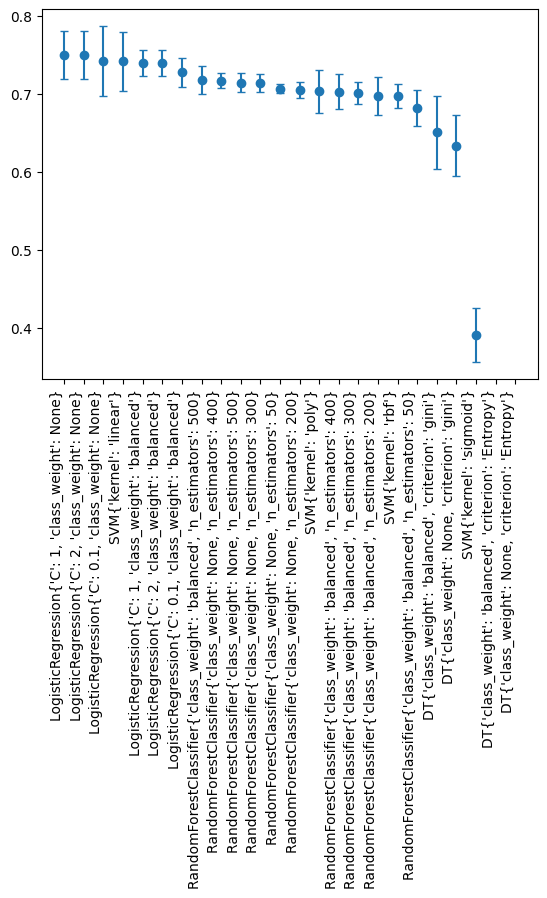

In [73]:
result = search.evaluate_model()
result['label'] = result['Estimator'].astype(str) + result['params'].astype(str)
std = result['std_test_score'].to_list()
mean_ = result['mean_test_score'].to_list()
x = result['label'].to_list()
plt.errorbar(x, mean_, std, linestyle='None', marker='o',capsize=3)
plt.xticks(rotation=90, ha='right')
plt.show()

### Try some conventional models

In [74]:
clf = LogisticRegression(C=1)
clf.fit(X_train,y_train)
preds = clf.predict(X_test)
print(report(y_test,preds,digits=4))

              precision    recall  f1-score   support

           0     0.7679    0.8600    0.8113       150
           1     0.6667    0.5185    0.5833        81

    accuracy                         0.7403       231
   macro avg     0.7173    0.6893    0.6973       231
weighted avg     0.7324    0.7403    0.7314       231



In [87]:
clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
preds = clf.predict(X_test)
print(report(y_test,preds,digits=4))

              precision    recall  f1-score   support

           0     0.7574    0.8533    0.8025       150
           1     0.6452    0.4938    0.5594        81

    accuracy                         0.7273       231
   macro avg     0.7013    0.6736    0.6810       231
weighted avg     0.7180    0.7273    0.7173       231



### will the performance improved if i use AdaBoost with best model in above graph?

In [75]:
models = [LogisticRegression(C=1),LogisticRegression(C=2)]
for model in models:
    print(type(model).__name__)
    clf = AdaBoostClassifier(n_estimators=100, random_state=0,estimator=model)
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    print(report(y_test,preds,digits=4))

LogisticRegression
              precision    recall  f1-score   support

           0     0.7765    0.8800    0.8250       150
           1     0.7049    0.5309    0.6056        81

    accuracy                         0.7576       231
   macro avg     0.7407    0.7054    0.7153       231
weighted avg     0.7514    0.7576    0.7481       231

LogisticRegression
              precision    recall  f1-score   support

           0     0.7765    0.8800    0.8250       150
           1     0.7049    0.5309    0.6056        81

    accuracy                         0.7576       231
   macro avg     0.7407    0.7054    0.7153       231
weighted avg     0.7514    0.7576    0.7481       231



## 5. Wait, Can I use other Boosting model?

In [30]:
!pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 6.8 MB/s eta 0:00:00


In [76]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.2, n_estimators=100, objective='binary:logistic',
                     nthread=1)

In [77]:
xgb.fit(X_train,y_train)
preds = xgb.predict(X_test)
print(report(y_test,preds,digits=4))

              precision    recall  f1-score   support

           0     0.7987    0.8467    0.8220       150
           1     0.6806    0.6049    0.6405        81

    accuracy                         0.7619       231
   macro avg     0.7396    0.7258    0.7313       231
weighted avg     0.7573    0.7619    0.7584       231



### 6. Wait, I want to do some gridsearch for xgboosting algorithm?

In [81]:
models = {
    'XGBoost': XGBClassifier(objective='binary:logistic',
                     nthread=1),
}
params = { 
    'XGBoost': {
        'n_estimators': [100,200,400,500],
               'learning_rate':[0.01,0.05,0.1,0.2,0.3]}
}

In [82]:
search = HyperclassifierSearch(models, params)
best_model = search.train_model(X_train, y_train, cv=5,scoring='f1_macro')

Search for XGBoost ...
Search is done.


results round for: XGBoost


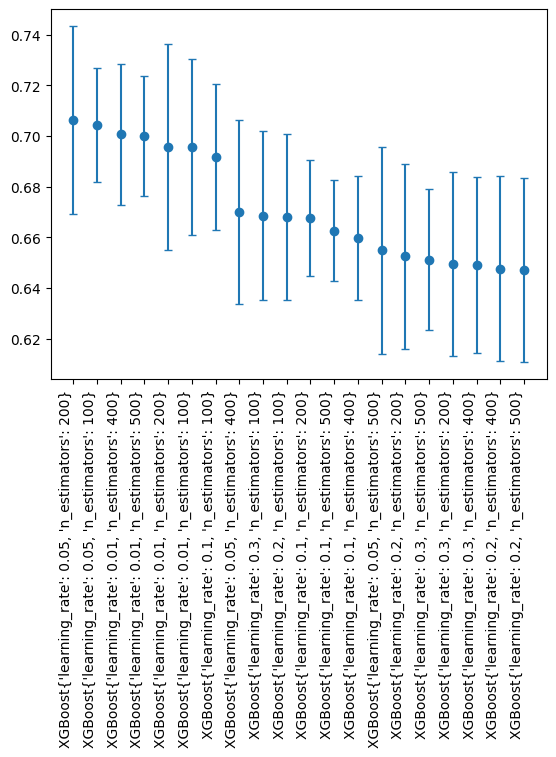

In [83]:
result = search.evaluate_model()
result['label'] = result['Estimator'].astype(str) + result['params'].astype(str)
std = result['std_test_score'].to_list()
mean_ = result['mean_test_score'].to_list()
x = result['label'].to_list()
plt.errorbar(x, mean_, std, linestyle='None', marker='o',capsize=3)
plt.xticks(rotation=90, ha='right')
plt.show()

In [85]:
xgb = XGBClassifier(learning_rate=0.05, n_estimators=200, objective='binary:logistic',
                     nthread=1)
xgb.fit(X_train,y_train)
preds = xgb.predict(X_test)
print(report(y_test,preds,digits=4))

              precision    recall  f1-score   support

           0     0.7818    0.8600    0.8190       150
           1     0.6818    0.5556    0.6122        81

    accuracy                         0.7532       231
   macro avg     0.7318    0.7078    0.7156       231
weighted avg     0.7468    0.7532    0.7465       231

